<a href="https://colab.research.google.com/github/cedoard/fine_tuned_bert/blob/master/notebooks/AlBERTo_End_to_End_(Fine_tuning_%2B_Predicting)_with_Cloud_TPU_Sentence_Classification_Tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Original code licensed by:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# AlBERTo End to End (Fine-tuning + Predicting) with Cloud TPU

## Overview

**BERT**, or **B**idirectional **E**mbedding **R**epresentations from **T**ransformers, is a new method of pre-training language representations which obtains state-of-the-art results on a wide array of Natural Language Processing (NLP) tasks. The academic paper can be found here: https://arxiv.org/abs/1810.04805.

In particular we use this Notebook for fine-tuning **AlBERTo**, the first italian undertanding language model for Twitter Language.

**Note:**  You will need a GCP (Google Compute Engine) account and a GCS (Google Cloud 
Storage) bucket for this Colab to run.

Please follow the [Google Cloud TPU quickstart](https://cloud.google.com/tpu/docs/quickstart) for how to create GCP account and GCS bucket. 

You can learn more about Cloud TPU at https://cloud.google.com/tpu/docs.

## Instructions

<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Train on TPU</h3>

   1. Create a Cloud Storage bucket for your TensorBoard logs at http://console.cloud.google.com/storage and fill in the BUCKET parameter in the "Parameters" section below.
 
   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.

### Install/Import required modules

In [ ]:
!pip install tensorflow==1.14.0

!pip install gcsfs 
!pip install fsspec 

!pip install ekphrasis
#!pip install pandas
#!pip install numpy

In [ ]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

#PREPARE TRAINING SENTENCES
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import pandas as pd
import numpy as np
import re


### Set up your TPU environment


Google Cloud Shell commands (see: [Google Cloud TPU quickstart](https://cloud.google.com/tpu/docs/quickstart))

`export PROJECT_ID=reberting`

`gcloud config set project $PROJECT_ID`

`gsutil mb -p ${PROJECT_ID} -c standard -l us-central1 -b on gs://bucket-rebert`

```
ctpu up --project=${PROJECT_ID} \
 --zone=us-central1-b \
 --tf-version=1.14 \
 --name=tpu-alberto
```






In this section, you perform the following tasks:

*   Set up a Colab TPU running environment
*   Verify that you are connected to a TPU device
*   Upload your credentials to TPU to access your GCS bucket.

In [ ]:
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()

with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

### Prepare and import BERT modules
​
With your environment configured, you can now prepare and import the BERT modules. The following step clones the source code from GitHub and import the modules from the source. 


In [ ]:
!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
from run_classifier import *
import modeling
import optimization
import tokenization

Cloning into 'bert_repo'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 315.49 KiB | 4.04 MiB/s, done.
Resolving deltas: 100% (185/185), done.



### Define Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/My Drive/Colab Notebooks/data/"
MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/model/"

Mounted at /content/drive


In [ ]:
TASK = 'sharing_mobility' #@param {type:"string"}
BUCKET = 'bucket-rebert' #@param {type:"string"}
INIT_MODEL = 'alberto_model.ckpt'

assert BUCKET, 'Must specify an existing GCS bucket name'
BUCKET_DIR = 'gs://{}'.format(BUCKET)

#INPUT PATH
TRAIN_TEST_DATA = 'gs://{}/train_test_data/'.format(BUCKET)

#OUTPUT PATH
OUTPUT_DIR_MODEL = 'gs://{}/{}/models/'.format(BUCKET, TASK)
tf.gfile.MakeDirs(OUTPUT_DIR_MODEL)
OUTPUT_DIR_RESULT = 'gs://{}/{}/result/'.format(BUCKET, TASK)
tf.gfile.MakeDirs(OUTPUT_DIR_RESULT)
OUTPUT_DIR_MODEL_TO_EXPORT = 'gs://{}/{}/models_export/'.format(BUCKET, TASK)
tf.gfile.MakeDirs(OUTPUT_DIR_MODEL)

print('***** Model output directory: {} *****'.format(OUTPUT_DIR_MODEL))

#CONFIGURE AlBERTo MODEL
BERT_CONFIG_FILE = 'gs://{}/alberto_files/config.json'.format(BUCKET) #@param {type:"string"}
VOCAB_FILE = 'gs://{}/alberto_files/vocab.txt'.format(BUCKET) #@param {type:"string"}
INIT_CHECKPOINT = 'gs://{}/alberto_files/{}'.format(BUCKET,INIT_MODEL) #@param {type:"string"}

***** Model output directory: gs://bucket-rebert/sharing_mobility/models/ *****


### Initialize BERT hyperparams and initialize TPU config.

In [ ]:
#SET THE PARAMETERS
TRAIN_BATCH_SIZE = 512
PREDICT_BATCH_SIZE = 512
EVAL_BATCH_SIZE = 512
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 10.0
MAX_SEQ_LENGTH = 128
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 500

# Setup TPU related config
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
NUM_TPU_CORES = 8
ITERATIONS_PER_LOOP = 1000

def get_run_config(output_dir):
  return tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=output_dir,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))


In [ ]:
#Labels used for annotating sentences
label_list = [0, 1]

#Inizialize BERT tokenizer
tokenizer = tokenization.FullTokenizer(VOCAB_FILE, do_lower_case=True)
tokenizer.tokenize("dovevo arrivare in università luiss e si è spento perché è entrato nella zona in cui non può più circolare ma va va")

### Prepare the training data

In [ ]:
text_processor = TextPreProcessor (
    # terms that will be normalized
    normalize=[ 'url' , 'email', 'user', 'percent', 'money', 'phone', 'time', 'date', 'number'] ,
    # terms that will be annotated
    annotate={"hashtag"} ,
    fix_html=True ,  # fix HTML tokens

    unpack_hashtags=True ,  # perform word segmentation on hashtags

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts = [ emoticons ]
)

def ekphrasis_preprocess(text_processor, s):
  s = s.lower()
  s = str(" ".join(text_processor.pre_process_doc(s)))
  s = re.sub(r"[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]", ' ', s)
  s = re.sub(r"\s+", ' ', s)
  s = re.sub(r'(\w)\1{2,}',r'\1\1', s)
  s = re.sub ( r'^\s' , '' , s )
  s = re.sub ( r'\s$' , '' , s )
  return s

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt
Reading english - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_2grams.txt
Reading english - 1grams ...


In [ ]:
#LOAD TRAINING AND TEST DATA
data = pd.read_excel(os.path.join(TRAIN_TEST_DATA,'MERGED_micromobilita_3012.xlsx'))
data = data.loc[~data.sentiment.isin(['NEUTRAL'])]
data = data.dropna().reset_index(drop=True)
data.loc[data.sentiment=='POS',"sentiment"] = 1
data.loc[data.sentiment=='NEG',"sentiment"] = 0

print(data.sentiment.unique())

data.head()

[0 1]


,keywords,date,comment,sentiment
0,ecooltra,2020-11-09 16:40:03,La mia esperienza personale è pessima. Gli ult...,0
1,bird,2020-11-09 13:59:23,"Pessima esperienza, applicazione instabile e p...",0
2,mobike,2020-11-09 13:25:17,"Peccato, il servizio è davvero valido ma l'app...",0
3,lime,2020-11-09 08:28:53,PESSIMO. Mi ha sbloccato la bici cambiandole c...,0
4,wind,2020-11-09 02:02:16,Mi hanno dato una multa di 73 euro non lo so p...,0


In [ ]:
#PREPROCESS TRAINING AND TEST DATA
sentences_labelled = data[['comment', 'sentiment']].values.tolist()
np.random.shuffle(sentences_labelled)

split = int(len(sentences_labelled)*0.8)
sentences_labelled_train, sentences_labelled_test = sentences_labelled[:split], sentences_labelled[split:]

sentences = [s[0] for s in sentences_labelled]
labels = [s[1] for s in sentences_labelled]
sentence_train, sentence_test = sentences[:split], sentences[split:]
labels_train, labels_test = labels[:split], labels[split:]

sentences_labelled_filtered = [[s[1],ekphrasis_preprocess(text_processor, s[0])] for s in sentences_labelled]
sentences_labelled_filtered_train, sentences_labelled_filtered_test = sentences_labelled_filtered[:split], sentences_labelled_filtered[split:]

print(len(sentences_labelled_filtered),len(sentences_labelled_filtered_train),len(sentences_labelled_filtered_test))

8042 6433 1609


In [ ]:
'''
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExample's using the constructor provided in the BERT library.

    text_a is the text we want to classify, which in this case, is the Request field in our Dataframe.
    text_b is used if we're training a model to understand the relationship between sentences (i.e. is text_b a translation of text_a? Is text_b an answer to the question asked by text_a?). This doesn't apply to our task, so we can leave text_b blank.
    label is the label for our example, i.e. True, False

'''

f = lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                           text_a = x[1], 
                           text_b = None, 
                           label = int(x[0])
                           )

f2 = lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                            text_a = x[1], 
                            text_b = None, 
                            label = 0
                            )

train_examples = map(f,sentences_labelled_filtered_train)
train_examples = list(train_examples)
train_examples = np.array(train_examples)

test_examples = map(f2,sentences_labelled_filtered_test)
test_examples = list(test_examples)
test_examples = np.array(test_examples)

print(test_examples.shape)
print(train_examples.shape)

(1609,)
(6433,)


In [ ]:
#Test data just created
for r in train_examples[:10]:
  print(r.text_a, r.label)
print("-"*150)
#Test data just created
for r in test_examples[:10]:
  print(r.text_a, r.label)

favolosa app complimenti se volete <number> minuti gratis utilizzare questo codice gnzdh 1
ottima la app la localizzazione degli scooter precisa ho preso x ora solo <number> volte ma ottimo servizio 1
do <number> stelle è tutto perfetto unica pecca applicazione un po lenta 1
a quanto pare sui telefoni xiaomi ci sono problemi per quanto riguarda l invio dell sms per la conferma del numero di telefono 0
codice <number> sblocchi gratis bdak s 1
la geolocalizzazione dell app lascia a desiderare non si aggiorna o lo fa in ritardo non permette di attivare la navigazione verso un monopattino inoltre la cartina stessa risulta solo con nord in alto non è possibile orientarla nel senso di marcia ogni tanto si blocca e non si riesce a sbloccare il mezzo parere mio <money> per il solo sblocco del mezzo mi sembra eccessivo altra cosa purtroppo non avvisano tempestivamente gli utenti della sospensione del servizio 0
bello a le ruote pikkole cio sempre paura de andare a sbatte addosso a una macchina 

In [ ]:
'''
Il metodo "convert_examples_to_features" crea le features da dare in input alla rete BERT:
  - restituisce un array di oggetti "InputFeatures"
  - "InputFeatures" ha i seguenti attributi:
          - input_ids
          - input_mask
          - segment_ids
          - label_id

'''

train_features = convert_examples_to_features(
      train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

In [ ]:
print(train_examples[0].text_a)
print(train_features[0].input_ids)
print(train_features[0].input_mask)
print(train_features[0].segment_ids)
print(train_features[0].label_id)

favolosa app complimenti se volete <number> minuti gratis utilizzare questo codice gnzdh
[2, 10968, 337, 662, 42, 804, 6, 13455, 14368, 127748, 453, 683, 7522, 79, 2242, 5849, 83057, 1431, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Fine-tune pretrained BERT Model

This section demonstrates fine-tuning from a pre-trained BERT TF Hub module and running predictions.


In [ ]:
BERT_CONFIG= modeling.BertConfig.from_json_file(BERT_CONFIG_FILE)

#inizialize parameters
num_train_steps = int(len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)+1
num_warmup_steps = int(NUM_TRAIN_EPOCHS * WARMUP_PROPORTION)
print(num_train_steps)
print(num_warmup_steps)

126
1


In [ ]:
model_fn = model_fn_builder(
  bert_config=BERT_CONFIG,
  num_labels=len(label_list),
  init_checkpoint=INIT_CHECKPOINT,
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  use_tpu=True,
  use_one_hot_embeddings=True
)

estimator = tf.contrib.tpu.TPUEstimator(
  use_tpu=True,
  model_fn=model_fn,
  config=get_run_config(OUTPUT_DIR_MODEL),
  train_batch_size=TRAIN_BATCH_SIZE,
  eval_batch_size=EVAL_BATCH_SIZE,
  predict_batch_size=PREDICT_BATCH_SIZE,
)


In [ ]:
print("***** Running training *****")
print("  Num examples = %d", len(train_examples))
print("  Num labels = %d", len(label_list))
print("  Batch size = %d", TRAIN_BATCH_SIZE)
print("  Num steps = %d", num_train_steps)

train_input_fn = input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)

print('***** Started training at {} *****'.format(datetime.datetime.now()))
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('***** Finished training at {} *****'.format(datetime.datetime.now()))


### Make predictions from estimator

In [ ]:
# MODEL PREDICTIONS
input_features = convert_examples_to_features(
      test_examples,label_list, MAX_SEQ_LENGTH, tokenizer)
  

# Eval will be slightly WRONG on the TPU because it will truncate
# the last batch.

predict_input_fn = input_fn_builder(
    features=input_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)


predictions = estimator.predict(predict_input_fn)

print('***** Finished evaluation at {} *****'.format(datetime.datetime.now()))


In [ ]:
#SAVE IN BUCKLET RESULTS AND PRINT THEM
output_eval_file = os.path.join(OUTPUT_DIR_RESULT, "sharing_mobility_31122020_results.csv")
output_eval_file_drive = os.path.join(DATA_PATH, "sharing_mobility_31122020_results.csv")
with tf.gfile.GFile(output_eval_file, "w") as writer:
  print("***** Results *****")
  writer.write("{}\t{}\t{}\n".format("sentence", "actual", "predicted") )
  for example, prediction, label in zip(sentence_test, predictions, labels_test):
    #print('\t prediction:{} \t id:{} \t text_a: {}'.format( prediction['probabilities'][0],str(id),str(example) ) )
    writer.write("{}\t{}\t{}\n".format(example, label, prediction['probabilities'][1]))

***** Results *****
INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.
INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.
INFO:tensorflow:Outfeed finished for iteration (4, 0)
INFO:tensorflow:Stop infeed thread controller
INFO:tensorflow:Shutting down InfeedController thread.
INFO:tensorflow:InfeedController received shutdown signal, stopping.
INFO:tensorflow:Infeed thread finished, shutting down.
INFO:tensorflow:infeed marked as finished
INFO:tensorflow:Stop output thread controller
INFO:tensorflow:Shutting down OutfeedController thread.
INFO:tensorflow:OutfeedController received shutdown signal, stopping.
INFO:tensorflow:Outfeed thread finished, shutting down.
INFO:tensorflow:outfeed marked as finished
INFO:tensorflow:Shutdown TPU system.
INFO:tensorflow:prediction_loop marked as finished
INFO:tensorflow:prediction_loop marked as finished


### evaluate predictions

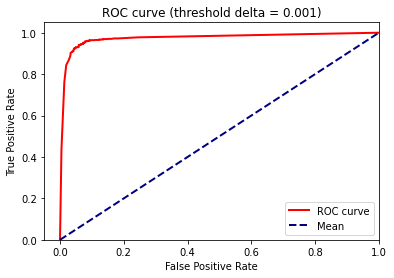

In [ ]:
import pandas as pd
import numpy as np

result = pd.read_csv(output_eval_file_drive, sep='\t', header = 0)
result.columns = ['sentence', 'actual', 'predicted']
result = result.dropna().reset_index(drop=True)

y_test = result.actual.values
y_proba = result.predicted.values

def get_confusion_matrix(y_true, y_pred):
    n_classes = len(np.unique(y_true))
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(y_true, y_pred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

def get_roc_curve(y_test, y_proba, delta=0.1):
    """
    Return the True Positive Rates (TPRs), False Positive Rates (FPRs), 
    and the threshold values, seperated by delta.
    """
    thresh = list(np.arange(0, 1, delta)) + [1]
    TPRs = []
    FPRs = []
    y_pred = np.empty(y_proba.shape)
    for th in thresh:
        y_pred[y_proba < th] = 0
        y_pred[y_proba >= th] = 1
        
        # confusion matrix from the function we defined
        (TN, FP), (FN, TP) = get_confusion_matrix(y_test, y_pred)
        
        TPR = TP / (TP + FN)  # sensitivity
        FPR = FP / (FP + TN)  # 1 - specificity
        TPRs.append(TPR)
        FPRs.append(FPR)
    return FPRs, TPRs, thresh

delta = 0.001
FPRs, TPRs, _ = get_roc_curve(y_test, y_proba, delta)

# Plot the ROC curve
import matplotlib.pyplot as plt

plt.plot(FPRs, TPRs, color='red',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (threshold delta = {delta})')
plt.legend(loc="lower right")
plt.show()

### Save Model

In [ ]:
#SAVE MODEL TO PB FORMAT

#TO DO PROVA A TOGLIERE NONE
def serving_input_fn():
    label_ids = tf.placeholder(tf.int32, [None], name='label_ids')
    input_ids = tf.placeholder(tf.int32, [None, MAX_SEQ_LENGTH], name='input_ids')
    input_mask = tf.placeholder(tf.int32, [None, MAX_SEQ_LENGTH], name='input_mask')
    segment_ids = tf.placeholder(tf.int32, [None, MAX_SEQ_LENGTH], name='segment_ids')
    input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn({
        'label_ids': label_ids,
        'input_ids': input_ids,
        'input_mask': input_mask,
        'segment_ids': segment_ids,
    })()
    return input_fn

estimator._export_to_tpu = False
estimator.export_saved_model(OUTPUT_DIR_MODEL_TO_EXPORT, serving_input_receiver_fn=serving_input_fn)

In [ ]:
!gsutil cp -r \
  gs://bucket-rebert/model_alberto_addestrato/1608503656/ \
  /content/drive/My Drive/Colab Notebooks/model

In [ ]:
!saved_model_cli show --dir 'gs://bucket-rebert/model_alberto_addestrato/1608504002' --all

## Make predictions from loaded model

### Load Model

In [ ]:
#LOAD MODEL
#LOAD_PATH = os.path.join(MODEL_PATH,'model_alberto_addestrato.h5','1608370941')
#LOAD_PATH_PB = os.path.join(MODEL_PATH,'model_alberto_addestrato.h5','1608370941','saved_model.pb')
LOAD_PATH_GCP = os.path.join(BUCKET_DIR,'model_alberto_addestrato','1608503656')
LOAD_PATH_GCP_PB = os.path.join(BUCKET_DIR,'model_alberto_addestrato.h5','1608503656','saved_model.pb')
print(LOAD_PATH_GCP)

gs://bucket-rebert/model_alberto_addestrato/1608503656


In [ ]:
from tensorflow.contrib import predictor

predict_fn = predictor.from_saved_model(LOAD_PATH_GCP)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from gs://bucket-rebert/model_alberto_addestrato/1608503656/variables/variables


### Make Predictions

In [ ]:
def convert_single_string_to_input_dict(tokenizer,example_string_prep):

  token_a = tokenizer.tokenize(example_string_prep)

  tokens = []
  segments_ids = []
  segment_ids = []

  tokens.append("[CLS]")
  segment_ids.append(0)
  for token in token_a:
    tokens.append(token)
    segment_ids.append(0)

  tokens.append('[SEP]')
  segment_ids.append(0)
    
  input_ids = tokenizer.convert_tokens_to_ids(tokens)
  input_mask = [1] * len(input_ids)

  while len(input_ids) < MAX_SEQ_LENGTH:
    input_ids.append(0)
    input_mask.append(0)
    segment_ids.append(0)

  label_id = [0]
  padding = [0] * MAX_SEQ_LENGTH
  print(len(input_ids),len(input_mask),len(segment_ids),len(label_id))
  return {"input_ids":[input_ids,padding], "input_mask":[input_mask,padding], "segment_ids":[segment_ids,padding], "label_ids":label_id}

def predict(tokenizer, predict_fn, input_str, MAX_SEQ_LENGTH):
    # CONVERT DATA TO FEATURES
    example_prep = ekphrasis_preprocess(input_str)
    example_features = convert_single_string_to_input_dict(tokenizer=tokenizer,
                                                       example_string=example_prep,
                                                       max_seq_length=MAX_SEQ_LENGTH)

    prediction = predict_fn(example_features)['probabilities'][0]
    prediction_dict = {'POS': round(prediction[1],4), 'NEG': round(prediction[0],4)}
    pprint(f"prediction: {prediction_dict}")
    return prediction

In [ ]:
# MODEL PREDICTIONS
example_sent_neg = "brutto e cattivo, sono veramente triste mi vorrei uccidere la mia vita non ha senso è terribile male male"
example_sent_pos = "sono euforico, mi piace così tanto che sono felice solo di poter essere vivo e poter prendere il monopattino per raggiungere l'apice della mia felicità"

print(predict(tokenizer, predict_fn, example_sent_neg, MAX_SEQ_LENGTH))
print(predict(tokenizer, predict_fn, example_sent_neg, MAX_SEQ_LENGTH))

In [ ]:
#PROVA PREDICT 1
input = '"input_ids":[2, 337, 7855, 13, 32584, 49470, 29, 16, 232, 492, 122, 93, 811, 452, 12, 38, 204, 16, 56481, 30, 53, 1754, 14, 931, 60, 786, 3516, 815, 53, 3153, 12, 24973, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],' \
    '"input_mask": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],' \
    '"segment_ids": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],' \
    '"label_ids": [0]}'
    
print(input_dict)

!saved_model_cli run \
    --dir 'gs://bucket-rebert/model_alberto_addestrato/1608503656' \
    --tag_set serve \
    --signature_def predict \
    --input_exprs '"instances":[{"examples":{"input_ids":[2, 337, 7855, 13, 32584, 49470, 29, 16, 232, 492, 122, 93, 811, 452, 12, 38, 204, 16, 56481, 30, 53, 1754, 14, 931, 60, 786, 3516, 815, 53, 3153, 12, 24973, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],"input_mask": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],"segment_ids": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],"label_ids": [0]}}]'

input=[{"input_ids":[2, 337, 7855, 13, 32584, 49470, 29, 16, 232, 492, 122, 93, 811, 452, 12, 38, 204, 16, 56481, 30, 53, 1754, 14, 931, 60, 786, 3516, 815, 53, 3153, 12, 24973, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],"input_mask": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],"segment_ids": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
#PROVA PREDICT 2
example_input = "This is the input string"
example1 = ekphrasis_preprocess(text_processor, example_input)
example2 = InputExample(guid=None,text_a = example1,text_b = None,label = 0)
example3 = convert_single_example(0,example2, label_list, MAX_SEQ_LENGTH, tokenizer)
print(example3)


INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: None
INFO:tensorflow:tokens: [CLS] this is the input string [SEP]
INFO:tensorflow:input_ids: 2 1869 721 291 43049 42225 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorf